# Predicting Optimal Fertilizers

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


Private-fertilizer-predic-playground-series-s5-e6 Version 1 notebook Full EDA

https://www.kaggle.com/code/les1781/optimal-fertilizer-predict-playground-series-s5-e6

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    LabelEncoder,    
    OneHotEncoder,
    StandardScaler
)
from sklearn.feature_selection import mutual_info_classif

# Initial analysis

In [3]:
# We load the data

fertilizers_train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv", index_col="id")

In [4]:
fertilizers_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,31.503565,4.025574,25.0,28.0,32.0,35.0,38.0
Humidity,750000.0,61.038912,6.647695,50.0,55.0,61.0,67.0,72.0
Moisture,750000.0,45.184147,11.794594,25.0,35.0,45.0,55.0,65.0
Nitrogen,750000.0,23.093808,11.216125,4.0,13.0,23.0,33.0,42.0
Potassium,750000.0,9.478296,5.765622,0.0,4.0,9.0,14.0,19.0
Phosphorous,750000.0,21.073227,12.346831,0.0,10.0,21.0,32.0,42.0


In [5]:
fertilizers_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 57.2+ MB


# Data wrangling

In [6]:
# We make a copy of the original dataset

fertilizers_new = fertilizers_train.copy()

In [7]:
# We confirm that there is no null values

null_values = pd.DataFrame(
        {f"Null Data" : fertilizers_new.isnull().sum(), 
         "Percentage" : (fertilizers_new.isnull().sum()) / (len(fertilizers_new)) * (100)})

null_values

,Null Data,Percentage
Temparature,0,0.0
Humidity,0,0.0
Moisture,0,0.0
Soil Type,0,0.0
Crop Type,0,0.0
Nitrogen,0,0.0
Potassium,0,0.0
Phosphorous,0,0.0
Fertilizer Name,0,0.0


In [8]:
# We check the duplicate data found

print(f"Length: {len(fertilizers_new.duplicated())}")
print(f"Duplicates: {fertilizers_new.duplicated().sum()}")

Length: 750000
Duplicates: 0


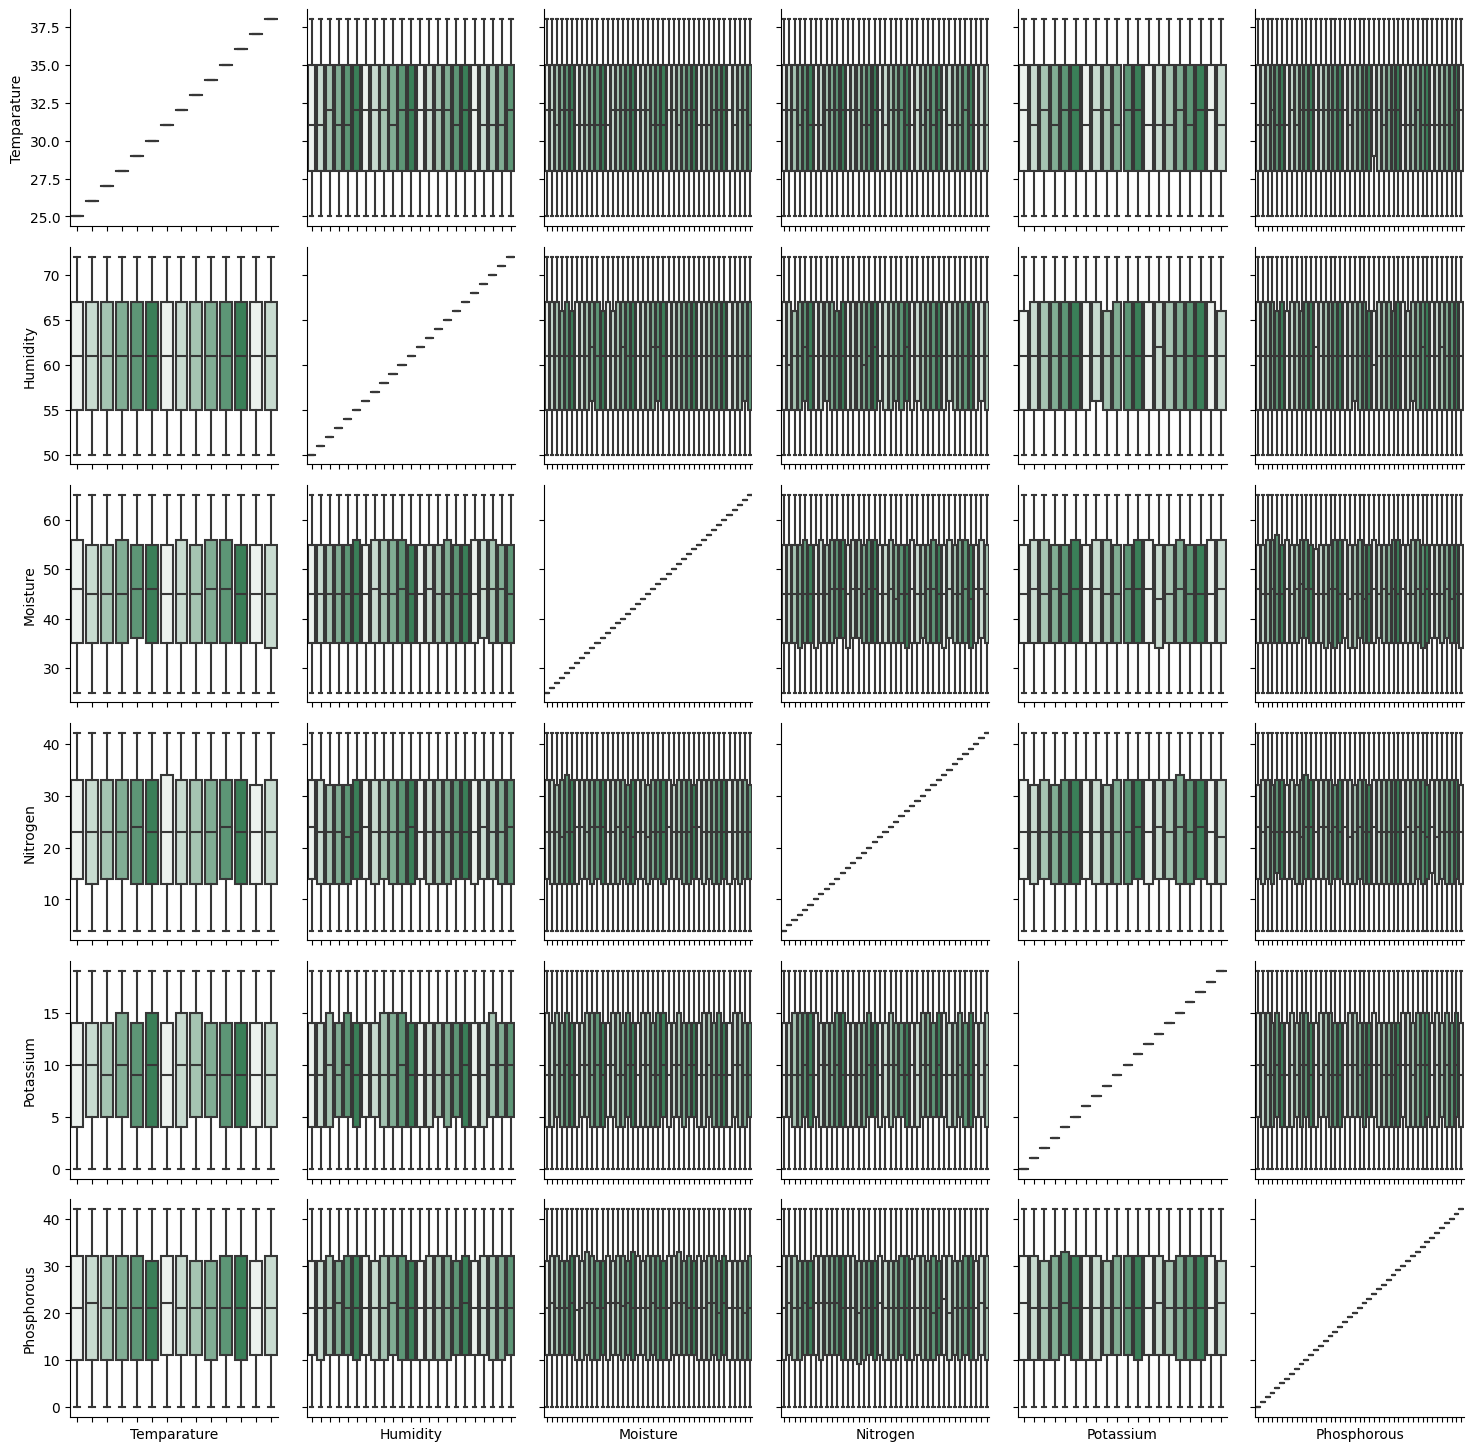

In [9]:
eval_out = sns.PairGrid(fertilizers_new, palette=sns.light_palette("seagreen"))
eval_out.map(sns.boxplot)
eval_out.tick_params(axis="both", labelbottom=False)

# Data Preprocessing

In [10]:
fertilizers_end = fertilizers_new.copy()

## Feature Engineering

First approach with original variables only.

## Encoding

In [11]:
# We apply LabelEncoder to the target variable

le = LabelEncoder()

fertilizers_end["Fertilizer Name"] = le.fit_transform(fertilizers_end["Fertilizer Name"])

In [12]:
# We create a df with the encoded categorical variables

cat_cols = fertilizers_end[["Soil Type", "Crop Type"]]
rest_cols = fertilizers_end.drop(columns=["Soil Type", "Crop Type"])
encoder = OneHotEncoder(sparse=False, drop="if_binary").set_output(transform="pandas")
cat_enc = encoder.fit_transform(cat_cols)
df_encoded = pd.concat([rest_cols, cat_enc], axis=1)

In [13]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temparature            750000 non-null  int64  
 1   Humidity               750000 non-null  int64  
 2   Moisture               750000 non-null  int64  
 3   Nitrogen               750000 non-null  int64  
 4   Potassium              750000 non-null  int64  
 5   Phosphorous            750000 non-null  int64  
 6   Fertilizer Name        750000 non-null  int64  
 7   Soil Type_Black        750000 non-null  float64
 8   Soil Type_Clayey       750000 non-null  float64
 9   Soil Type_Loamy        750000 non-null  float64
 10  Soil Type_Red          750000 non-null  float64
 11  Soil Type_Sandy        750000 non-null  float64
 12  Crop Type_Barley       750000 non-null  float64
 13  Crop Type_Cotton       750000 non-null  float64
 14  Crop Type_Ground Nuts  750000 non-null  f

In [14]:
df_encoded.corr(numeric_only=True).round(2)

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Fertilizer Name,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,...,Crop Type_Cotton,Crop Type_Ground Nuts,Crop Type_Maize,Crop Type_Millets,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat
Temparature,1.00,0.00,-0.00,-0.01,-0.01,0.00,0.00,0.01,0.00,-0.01,...,-0.00,0.01,0.00,0.00,0.00,0.00,-0.01,-0.00,-0.00,-0.00
Humidity,0.00,1.00,0.00,0.01,0.01,0.00,0.01,0.00,-0.00,-0.00,...,-0.00,0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00,-0.00,0.01
Moisture,-0.00,0.00,1.00,0.00,-0.00,-0.01,0.01,0.01,-0.00,-0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.01,0.00,-0.00,-0.01,-0.01
Nitrogen,-0.01,0.01,0.00,1.00,0.00,-0.01,-0.00,-0.00,0.00,0.00,...,0.00,-0.00,-0.00,0.00,-0.01,-0.01,-0.00,-0.00,0.00,0.01
Potassium,-0.01,0.01,-0.00,0.00,1.00,0.00,-0.01,-0.01,0.00,-0.00,...,0.00,0.00,-0.01,-0.01,0.00,0.00,0.00,-0.00,0.00,-0.00
Phosphorous,0.00,0.00,-0.01,-0.01,0.00,1.00,-0.01,0.00,0.00,-0.00,...,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00,-0.01,0.00
Fertilizer Name,0.00,0.01,0.01,-0.00,-0.01,-0.01,1.00,0.00,-0.01,-0.01,...,0.01,-0.01,0.01,0.01,-0.00,0.01,-0.03,-0.03,0.01,0.01
Soil Type_Black,0.01,0.00,0.01,-0.00,-0.01,0.00,0.00,1.00,-0.25,-0.25,...,-0.01,0.00,0.00,0.00,-0.01,0.01,-0.00,0.01,-0.00,-0.00
Soil Type_Clayey,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.01,-0.25,1.00,-0.24,...,0.01,-0.00,0.00,-0.00,-0.00,-0.01,0.01,0.00,0.00,0.00
Soil Type_Loamy,-0.01,-0.00,-0.00,0.00,-0.00,-0.00,-0.01,-0.25,-0.24,1.00,...,-0.00,-0.00,-0.01,-0.00,0.01,0.00,-0.00,-0.00,0.00,0.00


## Scaling

In [15]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,31.503565,4.025574,25.0,28.0,32.0,35.0,38.0
Humidity,750000.0,61.038912,6.647695,50.0,55.0,61.0,67.0,72.0
Moisture,750000.0,45.184147,11.794594,25.0,35.0,45.0,55.0,65.0
Nitrogen,750000.0,23.093808,11.216125,4.0,13.0,23.0,33.0,42.0
Potassium,750000.0,9.478296,5.765622,0.0,4.0,9.0,14.0,19.0
Phosphorous,750000.0,21.073227,12.346831,0.0,10.0,21.0,32.0,42.0
Fertilizer Name,750000.0,2.859791,1.967025,0.0,1.0,3.0,4.0,6.0
Soil Type_Black,750000.0,0.201275,0.400953,0.0,0.0,0.0,0.0,1.0
Soil Type_Clayey,750000.0,0.197843,0.398373,0.0,0.0,0.0,0.0,1.0
Soil Type_Loamy,750000.0,0.194467,0.395790,0.0,0.0,0.0,0.0,1.0


In [16]:
# We separate the target variable from the features

x_fertilizers = df_encoded.drop(columns="Fertilizer Name")
y_fertilizers = df_encoded["Fertilizer Name"]

In [17]:
# Numerical variables to scale

fertilizer_numeric = x_fertilizers[[
    "Temparature",
    "Humidity",
    "Moisture",
    "Nitrogen",
    "Potassium",
    "Phosphorous"
]]

scaler = StandardScaler().set_output(transform="pandas")
scale_num = scaler.fit_transform(fertilizer_numeric)

# We create a df with the remaining variables

fertilizer_rest = x_fertilizers.drop(columns=[
    "Temparature",
    "Humidity",
    "Moisture",
    "Nitrogen",
    "Potassium",
    "Phosphorous"
])

# We concatenate the dataframes

x_end = pd.concat([scale_num, fertilizer_rest], axis=1)

In [18]:
x_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temparature            750000 non-null  float64
 1   Humidity               750000 non-null  float64
 2   Moisture               750000 non-null  float64
 3   Nitrogen               750000 non-null  float64
 4   Potassium              750000 non-null  float64
 5   Phosphorous            750000 non-null  float64
 6   Soil Type_Black        750000 non-null  float64
 7   Soil Type_Clayey       750000 non-null  float64
 8   Soil Type_Loamy        750000 non-null  float64
 9   Soil Type_Red          750000 non-null  float64
 10  Soil Type_Sandy        750000 non-null  float64
 11  Crop Type_Barley       750000 non-null  float64
 12  Crop Type_Cotton       750000 non-null  float64
 13  Crop Type_Ground Nuts  750000 non-null  float64
 14  Crop Type_Maize        750000 non-null  f

In [19]:
x_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,-2.430625e-16,1.000001,-1.615563,-0.870328,0.123320,0.868556,1.613792
Humidity,750000.0,-5.286627e-16,1.000001,-1.660563,-0.908422,-0.005853,0.896716,1.648856
Moisture,750000.0,2.707263e-16,1.000001,-1.711306,-0.863459,-0.015613,0.832234,1.680080
Nitrogen,750000.0,3.865352e-17,1.000001,-1.702354,-0.899938,-0.008364,0.883210,1.685627
Potassium,750000.0,-5.222015e-17,1.000001,-1.643934,-0.950166,-0.082957,0.784253,1.651463
Phosphorous,750000.0,-2.046363e-18,1.000001,-1.706773,-0.896848,-0.005931,0.884987,1.694912
Soil Type_Black,750000.0,2.012747e-01,0.400953,0.000000,0.000000,0.000000,0.000000,1.000000
Soil Type_Clayey,750000.0,1.978427e-01,0.398373,0.000000,0.000000,0.000000,0.000000,1.000000
Soil Type_Loamy,750000.0,1.944667e-01,0.395790,0.000000,0.000000,0.000000,0.000000,1.000000
Soil Type_Red,750000.0,1.974693e-01,0.398090,0.000000,0.000000,0.000000,0.000000,1.000000


## Feature Selection

In [20]:
fertilizers_scores = mutual_info_classif(x_end, y_fertilizers)
fertilizers_scores = pd.Series(fertilizers_scores, name="Fertilizers MI Scores", index=x_end.columns)
fertilizers_scores = fertilizers_scores.sort_values(ascending=False)
fertilizers_scores

Moisture                 0.003740
Soil Type_Sandy          0.003416
Soil Type_Loamy          0.003344
Soil Type_Black          0.002937
Nitrogen                 0.002664
Phosphorous              0.002492
Soil Type_Clayey         0.002430
Soil Type_Red            0.002390
Humidity                 0.002140
Crop Type_Millets        0.002117
Crop Type_Pulses         0.002024
Potassium                0.001576
Crop Type_Cotton         0.001573
Crop Type_Oil seeds      0.001368
Crop Type_Maize          0.001334
Crop Type_Paddy          0.001205
Crop Type_Tobacco        0.001082
Crop Type_Wheat          0.000753
Temparature              0.000597
Crop Type_Sugarcane      0.000385
Crop Type_Ground Nuts    0.000000
Crop Type_Barley         0.000000
Name: Fertilizers MI Scores, dtype: float64

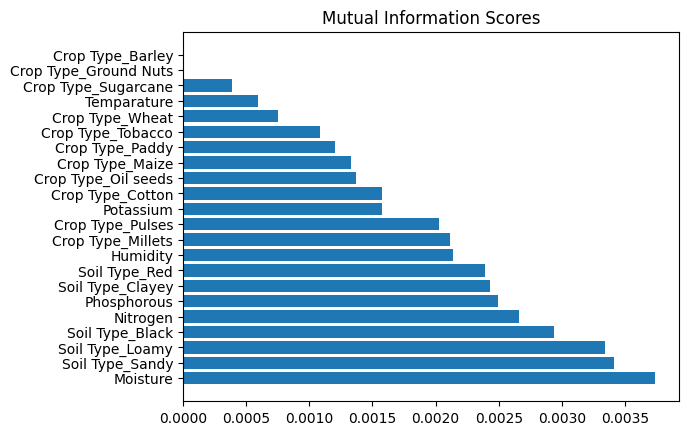

<Figure size 800x500 with 0 Axes>

In [21]:
scores = fertilizers_scores.sort_values(ascending=True)
width = np.arange(len(fertilizers_scores))
ticks = list(fertilizers_scores.index)
plt.barh(width, fertilizers_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()